1. x Test daten abspeichern und hier einlesen
2. x Ereigniskenndaten einlesen von csv
3. x zu den listenobjekten jeweils eventdaten hinzufügen (Dauer, hN, imax_60, Jährlichkeit)
4. Benchmark eventsauswählen
5. x load in_scaler und out_scaler
6. x testdaten sequenzieren und normalisieren
7. daten vorhersagen
8. Auswahl plotten mit delta time
    - wie plotten? evtl niederschlag mit balken von oben und predictions + actual ganglinie von unten
    - ereigniss kenndaten angeben (Dauer, hN, imax_60, Jährlichkeit)
9. x Scatterplot mit Evendaten

Auswertung aller Sequencen
- MAE
- RMSE
- Scatterplott Actual vs Fitted
- Boxplot mit quantilen für jeden Vorhersagezeitschritt
- siehe Plots burrichter




In [3]:
# Load Relevant Libraries, the model and the test data
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
from tensorflow.keras.models import model_from_json
import joblib
import pickle
import os
from modules.sequence_and_normalize import sequence_data, sequence_sample_random, sequence_list
from sklearn.preprocessing import MinMaxScaler


# Assign all relevant paths
model_folder = '05_models\\Gievenbeck_SingleNode_LSTM_20240328'
model_name = "Gievenbeck_SingleNode_LSTM_20240328"
model_path = os.path.join(model_folder, f'{model_name}.json')
weights_path = os.path.join(model_folder, f'{model_name}.weights.h5')
in_scaler_path = os.path.join(model_folder, 'in_scaler.pkl')
out_scaler_path = os.path.join(model_folder, 'out_scaler.pkl')
test_data_path = os.path.join(model_folder, 'test_data')
# Saving model design to JSON

# load json and create model
json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(weights_path)

# Load the scalers
in_scaler = joblib.load(in_scaler_path)
out_scaler = joblib.load(out_scaler_path)

# Load the test data
with open(test_data_path, 'rb') as file:
    test_data = pickle.load(file)

print("Loaded model from disk")

Loaded model from disk


In [4]:
# Load events data
events_df = pd.read_csv('02_input_data/events_FMO.csv')

# sequence data to list structure
lag = int(3 * 60 / 5)
delay = 0
p_steps = 6

in_vars=['duration', 'p']
out_vars=['Q_out']

seq_test = sequence_list(test_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                  out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)


In [5]:
# Print all Event meta data 
i=0
for obj in seq_test:
    print(i, obj[0])
    i += 1


0 {'name': 'Gievenbeck_2016-02-22 03 40 00_hN12 65', 'duration': 765, 'total precipitation': 12.649992823600769, 'max intensity': 15.83999605178833, 'intervall': 5, 'Ereignis': 'Aufgezeichnet'}
1 {'name': 'Gievenbeck_2014-07-24 13 45 00_hN11 22', 'duration': 310, 'total precipitation': 11.21999523540338, 'max intensity': 54.143999862670896, 'intervall': 5, 'Ereignis': 'Aufgezeichnet'}
2 {'name': 'Gievenbeck_e2_T20D20', 'duration': 255, 'total precipitation': 24.099995930989582, 'max intensity': 156.2400100708008, 'intervall': 5, 'Ereignis': 'Euler Typ 2'}
3 {'name': 'Gievenbeck_e2_T3D90', 'duration': 325, 'total precipitation': 23.0799986521403, 'max intensity': 94.72800750732422, 'intervall': 5, 'Ereignis': 'Euler Typ 2'}
4 {'name': 'Gievenbeck_e2_T3D1440', 'duration': 1675, 'total precipitation': 47.109984089930855, 'max intensity': 93.36000716686249, 'intervall': 5, 'Ereignis': 'Euler Typ 2'}
5 {'name': 'Gievenbeck_e2_T2D540', 'duration': 775, 'total precipitation': 32.5499846140543

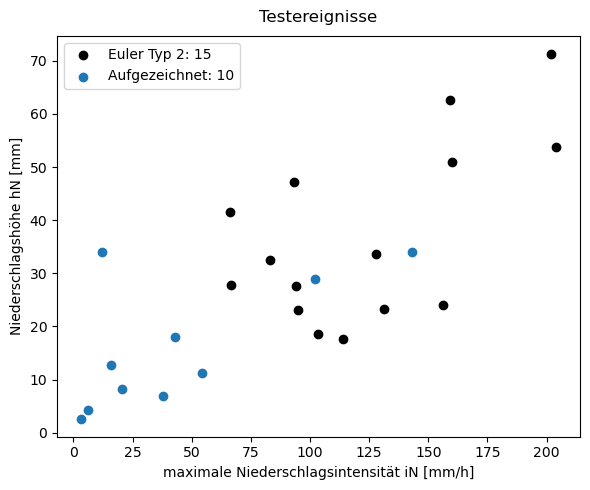

In [6]:
# Extract total precipitation and max intensity from seq_test
e2_precipitation = [obj[0]['total precipitation'] for obj in seq_test if obj[0]['Ereignis'] == 'Euler Typ 2']
e2_intensity = [obj[0]['max intensity'] for obj in seq_test if obj[0]['Ereignis'] == 'Euler Typ 2']

aufgezeichnet_precipitation = [obj[0]['total precipitation'] for obj in seq_test if obj[0]['Ereignis'] == 'Aufgezeichnet']
aufgezeichnet_intensity = [obj[0]['max intensity'] for obj in seq_test if obj[0]['Ereignis'] == 'Aufgezeichnet']

# Plot events precipitation and intensity in scatterplot
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot( e2_intensity, e2_precipitation,'o', color='black', label='Sample')
ax.scatter(aufgezeichnet_intensity, aufgezeichnet_precipitation, marker='o',  label='Events')

ax.set_xlabel('maximale Niederschlagsintensität iN [mm/h]')
ax.set_ylabel('Niederschlagshöhe hN [mm]')
ax.set_title('Testereignisse', pad=10)
ax.legend(labels=['Euler Typ 2: {}'.format(len(e2_precipitation)), 'Aufgezeichnet: {}'.format(len(aufgezeichnet_precipitation))])
plt.tight_layout()


In [7]:
# 1 is indata 2 is outdata
seq_test[21][1]
# seq_test[21][2]

array([[[0.        , 0.        ],
        [0.00106952, 0.        ],
        [0.00213904, 0.        ],
        ...,
        [0.03529412, 0.01224878],
        [0.03636364, 0.05196163],
        [0.03743316, 0.01196172]],

       [[0.00106952, 0.        ],
        [0.00213904, 0.        ],
        [0.00320856, 0.        ],
        ...,
        [0.03636364, 0.05196163],
        [0.03743316, 0.01196172],
        [0.03850267, 0.00038277]],

       [[0.00213904, 0.        ],
        [0.00320856, 0.        ],
        [0.00427807, 0.        ],
        ...,
        [0.03743316, 0.01196172],
        [0.03850267, 0.00038277],
        [0.03957219, 0.        ]],

       ...,

       [[0.01604278, 0.        ],
        [0.0171123 , 0.        ],
        [0.01818182, 0.        ],
        ...,
        [0.0513369 , 0.        ],
        [0.05240642, 0.        ],
        [0.05347594, 0.        ]],

       [[0.0171123 , 0.        ],
        [0.01818182, 0.        ],
        [0.01925134, 0.        ],
        .

In [29]:
# Predict = model.predict(seq_test[21][1])
# Predict
model.summary()
seq_test[1][1].shape
# seq_test[1][2][1]
# x_revert = in_scaler.inverse_transform(seq_test[1][1])
# test = seq_test[1][1]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,760 (6.88 KB)

 Trainable params: 586 (2.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,174 (4.59 KB)

(45, 36, 2)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


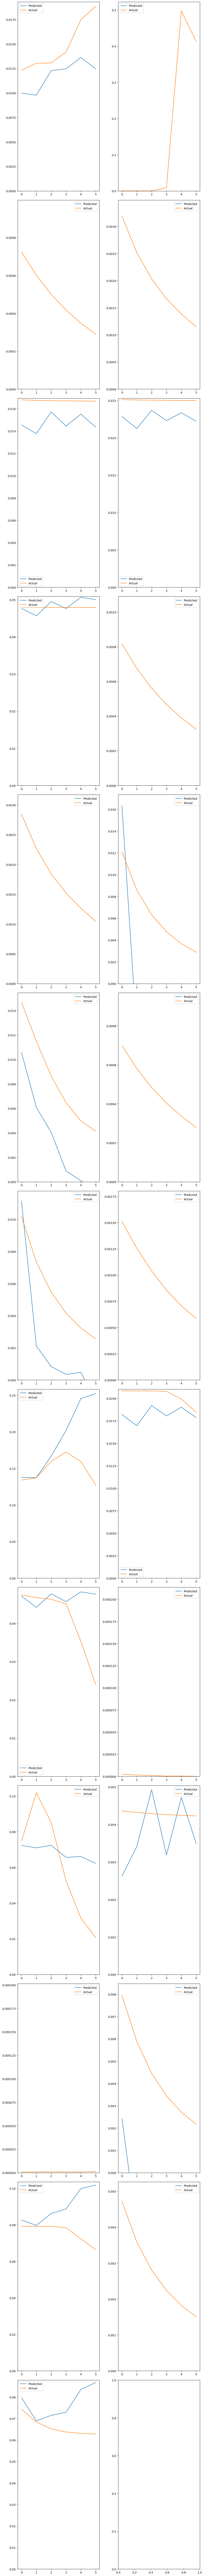

In [31]:
###############################!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
''' check if this is true: out_concat in data_preprocessing needs to be flattened with 
x_revert = x_revert.reshape(x_revert.shape[0], -1)
because is seems scaler wants differend input shape

'''

# Create a grid of subplots
plot_rows = int(len(seq_test)/2+1)
fig, axs = plt.subplots(plot_rows, 2, figsize=(10, 5*len(seq_test)))

# Loop through n_sample
for n_sample in range(len(seq_test)):
    Predict = model.predict(seq_test[n_sample][1])
    Predict_revert = out_scaler.inverse_transform(Predict)
    y_revert = seq_test[n_sample][2].reshape(seq_test[n_sample][2].shape[0], -1)
    y_revert = out_scaler.inverse_transform(y_revert)
    
    # x_revert = in_scaler.inverse_transform(seq_test[n_sample][1])
    

    n = int(len(seq_test[n_sample][1]) / 3)
    
    # Calculate column index
    col_index = n_sample % 2

    # Plotting the predicted and actual values in the corresponding subplot
    ax = axs[n_sample // 2, col_index]
    ax.plot(Predict_revert[n], label='Predicted')
    ax.plot(y_revert[n], label='Actual')
    ax.set_ylim(bottom=0)  # Set y-axis to start from zero
    ax.legend()
    
    # # Create a twin axis on the right side
    # ax2 = ax.twinx()
    # ax2.bar(x_revert[:, 0], color='blue', label='Niederschlag')
    # ax2.set_ylim(bottom=0)  # Set y-axis to start from zero
    # ax2.legend()



    # # Plotting the predicted and actual values in the corresponding subplot
    # axs[n_sample // 2, col_index].plot(Predict_revert[n], label='Predicted')
    # axs[n_sample // 2, col_index].plot(y_revert[n], label='Actual')
    # axs[n_sample // 2, col_index].set_ylim(bottom=0)  # Set y-axis to start from zero
    # axs[n_sample // 2, col_index].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [17]:
y_revert[n]
Predict_revert

array([[ 1.0522663e-01,  5.7348918e-02,  5.4582451e-02,  4.8360631e-02,
         4.5133911e-02,  3.9728731e-02],
       [ 6.0810089e-02,  3.4321085e-02,  3.1196637e-02,  2.0356130e-02,
         1.4608675e-02,  1.0528478e-02],
       [ 3.1902459e-02,  1.9582804e-02,  1.6808270e-02,  1.0733405e-02,
         6.3077221e-03,  5.0414647e-03],
       [ 1.5446843e-02,  1.0771826e-02,  8.4250355e-03,  5.5546975e-03,
         1.6659563e-03,  1.1715094e-03],
       [ 7.4138250e-03,  5.0278418e-03,  3.4973994e-03,  2.8361194e-03,
         9.6795190e-04,  7.2162779e-06],
       [ 4.1670436e-03, -1.9513299e-04, -6.0929870e-04,  2.9348861e-04,
         5.0697580e-04, -8.3730405e-04],
       [ 2.4088321e-03, -2.5262409e-03, -2.6542724e-03, -1.7694602e-03,
        -9.4822736e-04, -2.4128256e-03],
       [ 6.3082075e-04, -3.3144972e-03, -3.1594553e-03, -2.3152500e-03,
        -1.3225762e-03, -2.6804756e-03],
       [-9.0354559e-04, -3.6638728e-03, -3.2704596e-03, -2.4295433e-03,
        -1.4432510e-03, 